Import the neccessary libraries

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score,calinski_harabasz_score

Data Loading and Initial Preprocessing

In [56]:
# Load the dataset. The user specified it is tab-delimited
# We set "on_bad_lines" to "skip" in case of formatting errors in the file
try:
    df = pd.read_csv("marketing_campaign.csv",sep="\t",on_bad_lines="skip")
except FileNotFoundError:
    print("Error: 'marketing_campaign.csv' was not found. Please ensure it is in the same directory")
    exit()

In [57]:
# Display the initial shape of the data
print("Initial Data Shape:",df.shape)

Initial Data Shape: (2240, 29)


In [58]:
print("===== Data Information =====")
print(df.info())

===== Data Information =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsP

In [59]:
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0


Data Preprocessing

In [60]:
# Check for missing values
df_missing = df.isnull().sum()
print("===== Missing Values =====")
print(df_missing)

===== Missing Values =====
ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


In [61]:
# Handle missing 'Income' values by replacing them with the mean income.
# A small number of missing values (24 out of 2240) makes this a reasonable imputation strategy.
df['Income'].fillna(df['Income'].mean(), inplace=True)

# Drop columns that are not useful for clustering customer behavior or are constant
# 'ID' is a unique identifier.a
# 'Z_CostContact' and 'Z_Revenue' are constant columns (3 and 11, respectively) and offer no variance.
df.drop(columns=['ID', 'Z_CostContact', 'Z_Revenue'], inplace=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_8588\4190425577.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Income'].fillna(df['Income'].mean(), inplace=True)


In [62]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2240 non-null   int64  
 1   Education            2240 non-null   object 
 2   Marital_Status       2240 non-null   object 
 3   Income               2240 non-null   float64
 4   Kidhome              2240 non-null   int64  
 5   Teenhome             2240 non-null   int64  
 6   Dt_Customer          2240 non-null   object 
 7   Recency              2240 non-null   int64  
 8   MntWines             2240 non-null   int64  
 9   MntFruits            2240 non-null   int64  
 10  MntMeatProducts      2240 non-null   int64  
 11  MntFishProducts      2240 non-null   int64  
 12  MntSweetProducts     2240 non-null   int64  
 13  MntGoldProds         2240 non-null   int64  
 14  NumDealsPurchases    2240 non-null   int64  
 15  NumWebPurchases      2240 non-null   i

Feature Engineering and Selection

In [63]:
# Covert "Year_Birth" to "Age". We'l assume the current year is 2014, as that is the latest year in the dataset
df["Age"] = 2014 - df["Year_Birth"]
df.drop("Year_Birth",axis=1,inplace=True) # Drop the original "Year_Birth" column

In [64]:
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age
0,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57
1,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60
2,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49
3,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30
4,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33


In [65]:
df['Total_Spending'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + \
                       df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
# Calculate total number of purchases across all channels
df['Total_Purchases'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + \
                        df['NumCatalogPurchases'] + df['NumStorePurchases']

In [66]:
# Drop the date column as it's not a direct feature for clustering, but could be used ofr recency features
df.drop("Dt_Customer",axis=1,inplace=True)

In [68]:
# Drop the individual spending and purchase columns to reduce multicollininearity and simplify
mnt_cols = [col for col in df.columns if "Mnt" in col]
num_cols = [col for col in df.columns if "Num" in col]

df.drop(columns=mnt_cols + num_cols,inplace=True)
df.drop(columns=["AcceptedCmp1","AcceptedCmp2","AcceptedCmp3","AcceptedCmp4","AcceptedCmp5","Response","Complain"],inplace=True)

In [69]:
# Handle outliers in Age (e.g, people born too early)
df  = df[df["Age"] < 100]

In [70]:
# Feature Encoding: Convert the categorical variable into a numerical format
# "Education" and "Marital_Status" need to be converted to numerical features using one-hot encoding
df_encoded = pd.get_dummies(df,columns=["Education","Marital_Status"],drop_first=True)

In [71]:
# Drop any remaining original categorical columns that were not encoded
cols_to_drop = ["Education","Marital_Status"]
df_encoded.drop(columns=[col for col in cols_to_drop if col in df_encoded.columns],inplace=True,errors="ignore")

In [72]:
# Identify the features (columns) that will be used for clustering
X = df_encoded.copy()

Data Scaling

In [73]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transforms the features
X_scaled = scaler.fit_transform(X)

# Convert the scaled array back to a DataFrame for readability (optional, but good practice)
X_scaled_df = pd.DataFrame(X_scaled,columns=X.columns)

Dimensionality Reduction (PCA)

In [74]:
# Initialize PCA to reduce the features down to 2 components for easy  visualization
pca = PCA(n_components=2)

# Fit PCA to the scaled data and transform it
X_pca = pca.fit_transform(X_scaled_df)

# Create a  DataFrame for the PCA results
pca_df = pd.DataFrame(X_pca,columns=["PCA1","PCA2"])

Visualization before Clustering

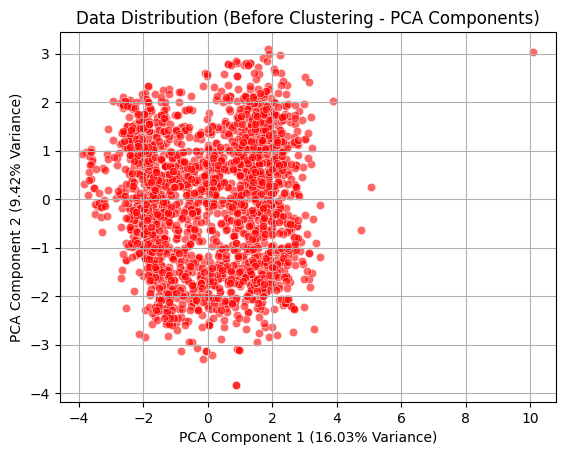

In [75]:
plt.Figure(figsize=(14,7))
# Create a scatter plot of the 2 PCA components to visualize the unclustered data
sns.scatterplot(x="PCA1",y="PCA2",data=pca_df,color="red",alpha=0.6)
plt.title("Data Distribution (Before Clustering - PCA Components)")
plt.xlabel(f"PCA Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)")
plt.ylabel(f"PCA Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)")
plt.grid(True)
plt.show()

Hyperparameter Tuning (Optimal K determination using Silhouette Score)

In [81]:
# We will test a range of cluster numbers (k) from 2 up to 10
k_range = range(2,11)
silhouette_scores = [] # List to store Silhouette Scores for each k

In [84]:
# Iterate through the range of k values
for k in k_range:
    # Initialize K-Means with the current k
    kmeans_model = KMeans(n_clusters=k,random_state=42,n_init=10,max_iter=300)
    # Train the model on the PCA-transformeed data
    kmeans_model.fit(X_pca)
    # Get the cluster labels
    labels = kmeans_model.labels_
    #  Calculate the Silhouette Score (higher is better)
    score = silhouette_score(X_pca,labels)
    silhouette_scores.append(score)

In [85]:
# Find the k value that resulted in the highest Silhouette Score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (k) determined by Silhouette Score: {optimal_k}")

Optimal number of clusters (k) determined by Silhouette Score: 2


Visualization of Silhouette Scores vs K

In [ ]:
'''plt.figure(figsize=(10,5))
plt.plot(k_range,silhouette_scores,marker="o",linestyle="--")
plt.scatter(optimal_k,np.max(silhouette_scores),color="red",s=200,label=f"Optimal k={optimal_k}")
plt.title("Silhouette Score Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.show()'''

Model Comparison and Evaluation

In [88]:
# Dictionary to store the results (model name, Silhouette Score, Calinski-Harabasz Index)
results = {}

#  Define the models to be compared. We will use the determined optimal_k for all models that require it
models = {
    "K-Means":KMeans(n_clusters=optimal_k,random_state=42,n_init=10),
    "Agglomerative":AgglomerativeClustering(n_clusters=optimal_k),
    # DBSCAN does not require the number of clusters (k). Its hyperparameters are eps and min_samples
    # These default parameters often need extensive tuning, but for this comparison, we use conservative setup
    "DBSCAN (eps=0.5,min_samples=5)":DBSCAN(eps=0.5,min_samples=5),
    "Gaussian Mixture Model (GMM)":GaussianMixture(n_components=optimal_k,random_state=42)
}

In [92]:
# Iterate through all models,train them and evaluate
print("===== Model Comparison Results =====")
for name,model in models.items():
    # DBSCAN and Agglomerative Clustering use the fit_predict method
    if name in ["K-Means","Agglomerative","DBSCAN (eps=0.5,min_samples=5)"]:
        # Fit the model and get the cluster labels
        labels = model.fit_predict(X_pca)
    # GMM uses the fit method, and then predict (or predict_proba)
    else:
        model.fit(X_pca)
        labels = model.predict(X_pca)


    # DBSCAN can result in noise points labeled as -1. We only calculate metrics on non-noise points.
    # If all labels are -1, the score calculation will fail, so we check for valid clusters
    if np.max(labels) < 0:
        silhouette = 0
        calinski = 0
        print(f"{name}: Failed to form more than one cluster (Noise).")
    elif len(np.unique(labels)) < 2:
        silhouette = 0
        calinski = 0
        print(f"{name}: Only one cluster formed.")
    else:
        # Calculate the Silhouette Score: Measures how similar an object is to its own cluster compared to others. Higher is better (range -1 to 1)
        silhouette = silhouette_score(X_pca,labels)
        # Calculate the Calinski_Harabaz Index: Measures the ratio of between-cluster dispersion to within-cluster dispersion. Higher is better
        calinski = calinski_harabasz_score(X_pca,labels)
        print(f"{name}:\n\tSilhouette Score: {silhouette:.4f}\n\tCalinski-Harabasz Index: {calinski:.2f}")


    results[name] = {
        "Silhouette Score":silhouette,
        "Calinski-Harabaz Index":calinski,
        "Labels":labels
    }

===== Model Comparison Results =====
K-Means:
	Silhouette Score: 0.4437
	Calinski-Harabasz Index: 2150.44
Agglomerative:
	Silhouette Score: 0.4287
	Calinski-Harabasz Index: 2030.10
DBSCAN (eps=0.5,min_samples=5):
	Silhouette Score: 0.4699
	Calinski-Harabasz Index: 28.42
Gaussian Mixture Model (GMM):
	Silhouette Score: 0.4430
	Calinski-Harabasz Index: 2139.14


In [93]:
# Determine the best model based on Silhouette Score
best_model_name = max(results, key=lambda k: results[k]['Silhouette Score'])
print(f"----- Conclusion: Best Clustering Model is {best_model_name} -----")

----- Conclusion: Best Clustering Model is DBSCAN (eps=0.5,min_samples=5) -----


In [94]:
# Store the labels from the best model in the PCA DataFrame
best_labels = results[best_model_name]["Labels"]
pca_df["Cluster"] = best_labels

Visualization After Clustering

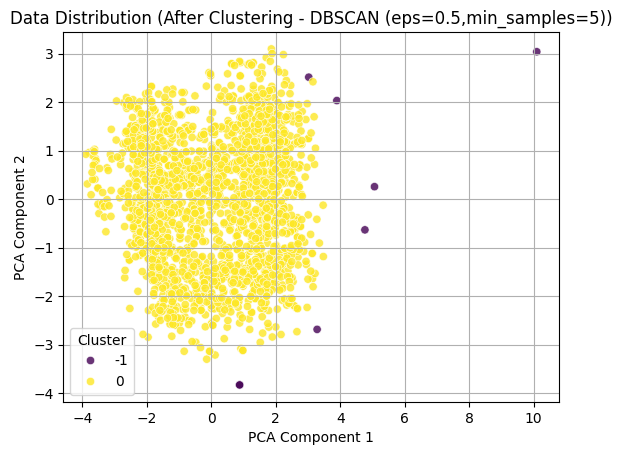

In [101]:
plt.Figure(figsize=(10,7))
# Create the scatter plot, coloring points by the predicted cluster label from the best model
sns.scatterplot(
    x="PCA1",
    y="PCA2",
    hue="Cluster", # Color points based on the "Cluster" column
    data=pca_df,
    palette="viridis", # Use a distinct color map
    legend="full",
    alpha=0.8
)

plt.title(f"Data Distribution (After Clustering - {best_model_name})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

New Prediction Input Function

In [ ]:
# Define a function to process new raw data and assign it to a cluster
def predict_new_customer_cluster(new_data, scaler, pca, best_model):
    """
    Takes a new customer's raw data, processes it, and assigns a cluster.

    Args:
        new_data (pd.DataFrame): A DataFrame containing a single new row of raw customer data.
        scaler (StandardScaler): The fitted StandardScaler object.
        pca (PCA): The fitted PCA object.
        best_model (object): The best-performing clustering model (e.g., K-Means).

    Returns:
        int: The assigned cluster label.
    """
    # Create the necessary encoded columns to match the training data structure
    new_data = new_data.copy()
    
    # 1. Feature Engineering (Age, Total_Spending, Total_Purchases) - must match training
    new_data['Age'] = 2014 - new_data['Year_Birth']
    new_data['Total_Spending'] = new_data[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
    new_data['Total_Purchases'] = new_data[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

    # 2. Select the core columns needed for clustering before one-hot encoding
    # This list must match the columns in the training data 'X' before encoding/scaling/PCA
    # We will reconstruct the exact features X was built from before the final scaling/PCA steps.
    
    # Recreate the list of features used in X (before encoding/dropping originals)
    feature_columns_before_encoding = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'Age', 'Total_Spending', 'Total_Purchases', 'Education', 'Marital_Status']
    
    # Ensure the new data has these columns. Fill missing engineered columns if needed.
    new_data = new_data.reindex(columns=feature_columns_before_encoding, fill_value=0)
    
    # 3. One-Hot Encoding: Must match columns created during training
    # Note: This is simplified. In a robust system, the encoder would be saved.
    
    # Re-create all possible dummy columns that were created in the training set (a bit of a hack for a single script)
    all_possible_dummies = df_encoded.columns.tolist()
    
    # Prepare the single row for encoding
    new_data_encoded = pd.get_dummies(new_data, columns=['Education', 'Marital_Status'], drop_first=True)
    
    # Select only the columns that were in the original training set, ensuring order and structure match
    final_cols = [col for col in all_possible_dummies if col != 'Cluster'] # exclude the cluster column we added for visualization
    
    # Reindex the new data row to have the same columns as the training data, filling missing encoded columns with 0
    new_data_processed = new_data_encoded.reindex(columns=final_cols, fill_value=0)
    
    # 4. Scaling
    # Apply the trained scaler to the processed row
    new_data_scaled = scaler.transform(new_data_processed)
    
    # 5. PCA
    # Apply the trained PCA transformation
    new_data_pca = pca.transform(new_data_scaled)
    
    # 6. Prediction
    # Use the best model to predict the cluster for the new PCA data point
    predicted_cluster = best_model.predict(new_data_pca)[0]

    return predicted_cluster

# --- 10. EXAMPLE PREDICTION ---

# Example: Define a new customer's data using the original column names required for calculation
# Note: We only need the columns used to derive the features (Income, Age, Spending, Education/Marital Status)
new_customer_data = pd.DataFrame({
    'Year_Birth': [1990],
    'Income': [95000],
    'Kidhome': [0],
    'Teenhome': [0],
    'Recency': [5],
    'MntWines': [1200],
    'MntFruits': [50],
    'MntMeatProducts': [500],
    'MntFishProducts': [10],
    'MntSweetProducts': [50],
    'MntGoldProds': [150],
    'NumDealsPurchases': [1],
    'NumWebPurchases': [10],
    'NumCatalogPurchases': [10],
    'NumStorePurchases': [15],
    'Education': ['Graduation'],
    'Marital_Status': ['Single'],
    # Add other columns from the original dataset with default values if not provided
    'Dt_Customer': ['01-01-2023'],
    'AcceptedCmp3': [0],
    'AcceptedCmp4': [0],
    'AcceptedCmp5': [0],
    'AcceptedCmp1': [0],
    'AcceptedCmp2': [0],
    'Complain': [0],
    'Response': [0],
    'NumWebVisitsMonth': [3],
})
# We need to make sure the best model variable is set correctly
if best_model_name == 'K-Means':
    best_model_instance = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(X_pca)
elif best_model_name == 'Agglomerative':
    best_model_instance = AgglomerativeClustering(n_clusters=optimal_k).fit(X_pca)
elif best_model_name == 'Gaussian Mixture Model (GMM)':
    best_model_instance = GaussianMixture(n_components=optimal_k, random_state=42).fit(X_pca)
else:
    # Use DBSCAN if it was the best, or K-Means as a fallback if DBSCAN failed (which it often does)
    best_model_instance = DBSCAN(eps=0.5, min_samples=5).fit(X_pca)


# Predict the cluster for the new customer
predicted_cluster_id = predict_new_customer_cluster(new_customer_data, scaler, pca, best_model_instance)

print(f"\n--- New Customer Prediction ---")
print(f"The new customer with high income and high spending is assigned to Cluster: {predicted_cluster_id}")
print(f"To interpret this, you would analyze the mean characteristics of Cluster {predicted_cluster_id} in the original data.")
